In [2]:
import xarray as xr
import numpy as np
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import wrf
import netCDF4 as nc
import warnings
import pyart
import tqdm
import metpy.calc as mpcalc
import pandas as pd
warnings.simplefilter("ignore")


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



<frozen importlib._bootstrap>:283: DeprecationWarning: the load_module() method is deprecated and slated for removal in Python 3.12; use exec_module() instead


0.3.0


In [3]:
def calc_grad_theta(theta):
    
    theta_np = theta.values
    dx, dy = mpcalc.lat_lon_grid_deltas(theta.XLONG.values, theta.XLAT.values)
    dtheta_dy, dtheta_dx = mpcalc.gradient(theta_np, deltas=[dy.to("km"), dx.to("km")])
    grad_theta = dtheta_dy + dtheta_dx
    grad_theta = xr.DataArray(grad_theta.data,dims=["south_north","west_east"])
    grad_theta["XLONG"] = theta.XLONG
    
    return grad_theta

def load_transect(tpath,t_fname,hpath,h_fname,mean_motion_top):

    ctrl = xr.open_dataset(tpath + t_fname)
    dbz = xr.open_dataset(hpath + "dbz_" + h_fname)
    ctrl_highres = xr.open_dataset(hpath + h_fname, decode_times=False)
    ctrl_highres_wrf = nc.Dataset(hpath + h_fname)
    ctrl["system_relative_along_transect_wind"] = ctrl["along_transect_wind"] - ctrl["along_transect_wind"].sel(vertical=slice(0,mean_motion_top)).\
                        mean(("vertical","cross_line_idx"))
    
    return ctrl.assign_coords({"transect":ctrl.transect}), ctrl_highres, ctrl_highres_wrf, dbz
    
def latlon_dist(lat, lon, lats, lons):

        #Calculate great circle distance (Harversine) between a lat lon point (lat, lon) and a list of lat lon
        # points (lats, lons)

        R = 6373.0

        lat1 = np.deg2rad(lat)
        lon1 = np.deg2rad(lon)
        lat2 = np.deg2rad(lats)
        lon2 = np.deg2rad(lons)

        dlon = lon2 - lon1
        dlat = lat2 - lat1

        a = np.sin(dlat / 2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2)**2
        c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))

        return (R * c)    
    
def plot_transect(ctrl):
    
    plt.figure(figsize=[18,4])
    plt.subplot(1,3,1)
    xr.plot.contourf(ctrl.sel(vertical=slice(0,6000)).theta_pert.mean("transect"),levels=np.arange(-4,0.5,0.5),cmap="Blues_r",alpha=0.7)
#    xr.plot.contour(ctrl.sel(vertical=slice(0,6000)).theta_pert.mean("transect"),levels=[-2],colors=["k"],linestyles="-")
    xr.plot.contour(ctrl.sel(vertical=slice(0,2000)).theta_pert.mean("transect"),levels=np.arange(-4,0.5,0.5),colors=["k"],linestyles="-",linewidths=0.5)    
    ctrl.sel(vertical=slice(0,6000,2),cross_line_idx=slice(2,50,10)).mean("transect").plot.quiver("cross_line_idx","vertical","system_relative_along_transect_wind","w",width=0.005,color="k",scale=100)
    plt.ylim([0,6000])

    plt.subplot(1,3,2)
    xr.plot.contourf(ctrl.sel(vertical=slice(0,6000)).ground_rel_ws.mean("transect"),levels=np.linspace(0,30,11),cmap="Reds")
    xr.plot.contour(ctrl.sel(vertical=slice(0,6000)).ground_rel_ws.mean("transect"),levels=[15,18],colors=["k","grey"])
    ctrl.sel(vertical=slice(0,6000,2),cross_line_idx=slice(2,50,10)).mean("transect").plot.quiver("cross_line_idx","vertical","system_relative_along_transect_wind","w",width=0.005,color="k",scale=100)
    plt.ylabel("")
    plt.ylim([0,6000])

    plt.subplot(1,3,3)
    xr.plot.contourf(ctrl.sel(vertical=slice(0,6000)).p_pert.mean("transect"),levels=np.linspace(-0.5,0.5,11),cmap="RdBu_r")
    xr.plot.contour(ctrl.sel(vertical=slice(0,6000)).buoyancy.mean("transect"),levels=[-0.10,-0.05,0,0.02,0.04],colors="k",linewidths=[3])
    ctrl.sel(vertical=slice(0,6000,2),cross_line_idx=slice(2,50,10)).mean("transect").plot.quiver("cross_line_idx","vertical","system_relative_along_transect_wind","w",width=0.005,color="k",scale=100)
    plt.ylabel("")
    plt.ylim([0,6000])
    
def read_grid(t):
    path1 = "/g/data/w40/ab4502/IN2023_V06/data/radar/opol/grids/opol_"
    path2 = "_grids.nc"    
    grid = pyart.io.read_grid(path1+t+path2).to_xarray()
    obs_lon, obs_lat = np.meshgrid(grid.lon.values,grid.lat.values)
    return grid,obs_lon,obs_lat

def read_swirl(t,step=10,z=1500):
    path = "/g/data/w40/ab4502/IN2023_V06/data/radar/510/20231016/510_20231016_"
    swirl = xr.open_dataset(path+t+".nc")
    mask = swirl.retrieval_mask.sel(z=z)
    u = swirl.vx.sel(z=z)
    v = swirl.vy.sel(z=z)
    u = xr.where(mask==0,np.nan,u)
    v = xr.where(mask==0,np.nan,v)
    u = u.isel(y=range(0,swirl.y.shape[0],step),x=range(0,swirl.x.shape[0],step))
    v = v.isel(y=range(0,swirl.y.shape[0],step),x=range(0,swirl.x.shape[0],step))
    lon = swirl.longitude.isel(y=range(0,swirl.y.shape[0],step),x=range(0,swirl.x.shape[0],step))
    lat = swirl.latitude.isel(y=range(0,swirl.y.shape[0],step),x=range(0,swirl.x.shape[0],step))    
    return lon,lat,u,v    

def get_radar_transects():
    #Set up radar transects
    radar_transect_lon1 = np.array([153.9,154.4])
    radar_transect_lat1 = np.array([-36.15,-35.87])

    radar_transect_lons = []
    radar_transect_lats = []
    for i in np.arange(-0.3,0.45,0.025):
        radar_transect_lons.append(radar_transect_lon1 + i)
        radar_transect_lats.append(radar_transect_lat1 - i)
    return radar_transect_lats,radar_transect_lons

In [4]:
tpath = "/g/data/w40/ab4502/WRF_simulations/transects/"
hpath = "/g/data/w40/ab4502/WRF_simulations/tasman_d04_20231015_20231016_ramssa_shortlead/"
mean_motion_top = 6000
plot_radar=False

t_fname = ["tasman_d04_20231015_20231016_ramssa_shortlead_02:30:00.nc",
           "tasman_d04_20231015_20231016_ramssa_shortlead_03:00:00.nc",
           "tasman_d04_20231015_20231016_ramssa_shortlead_03:30:00.nc",
           "tasman_d04_20231015_20231016_ramssa_shortlead_04:00:00.nc"]
h_fname = ["highres_d04_2023-10-16_02:30:00",
           "highres_d04_2023-10-16_03:00:00",
           "highres_d04_2023-10-16_03:30:00",
           "highres_d04_2023-10-16_04:00:00"]
ctrl_list = []
ctrl_highres_list = []
ctrl_highres_wrf_list = []
ctrl_dbz_list = []

for t, h in tqdm.tqdm(zip(t_fname,h_fname)):

    ctrl, ctrl_highres, ctrl_highres_wrf, ctrl_dbz = load_transect(tpath,t,hpath,h,mean_motion_top)
    ctrl_list.append(ctrl)
    ctrl_highres_list.append(ctrl_highres)
    ctrl_highres_wrf_list.append(ctrl_highres_wrf)    
    ctrl_dbz_list.append(ctrl_dbz)        
    

4it [00:03,  1.06it/s]


In [5]:
tpath = "/g/data/w40/ab4502/WRF_simulations/transects/"
hpath = "/g/data/w40/ab4502/WRF_simulations/tasman_d04_20231015_20231016_ramssa_shortlead_3Kplus/"
mean_motion_top = 6000
plot_radar = True

t_fname = ["tasman_d04_20231015_20231016_ramssa_shortlead_3Kplus_02:30:00.nc",
           "tasman_d04_20231015_20231016_ramssa_shortlead_3Kplus_03:00:00.nc",
           "tasman_d04_20231015_20231016_ramssa_shortlead_3Kplus_03:30:00.nc",
           "tasman_d04_20231015_20231016_ramssa_shortlead_3Kplus_04:00:00.nc"]
h_fname = ["highres_d04_2023-10-16_02:30:00",
           "highres_d04_2023-10-16_03:00:00",
           "highres_d04_2023-10-16_03:30:00",
           "highres_d04_2023-10-16_04:00:00"]
plus3K_list = []
plus3K_highres_list = []
plus3K_highres_wrf_list = []
plus3K_dbz_list = []

for t, h in tqdm.tqdm(zip(t_fname,h_fname)):

    plus3K, plus3K_highres, plus3K_highres_wrf, plus3K_dbz = load_transect(tpath,t,hpath,h,mean_motion_top)
    plus3K_list.append(plus3K)
    plus3K_highres_list.append(plus3K_highres)
    plus3K_highres_wrf_list.append(plus3K_highres_wrf)    
    plus3K_dbz_list.append(plus3K_dbz)        
    

4it [00:00, 10.32it/s]


In [6]:
tpath = "/g/data/w40/ab4502/WRF_simulations/transects/"
hpath = "/g/data/w40/ab4502/WRF_simulations/tasman_d04_20231015_20231016_ramssa_shortlead_3Kminus/"
mean_motion_top = 6000
plot_radar = True

t_fname = ["tasman_d04_20231015_20231016_ramssa_shortlead_3Kminus_02:30:00.nc",
           "tasman_d04_20231015_20231016_ramssa_shortlead_3Kminus_03:00:00.nc",
           "tasman_d04_20231015_20231016_ramssa_shortlead_3Kminus_03:30:00.nc",
           "tasman_d04_20231015_20231016_ramssa_shortlead_3Kminus_04:00:00.nc"]
h_fname = ["highres_d04_2023-10-16_02:30:00",
           "highres_d04_2023-10-16_03:00:00",
           "highres_d04_2023-10-16_03:30:00",
           "highres_d04_2023-10-16_04:00:00"]
minus3K_list = []
minus3K_highres_list = []
minus3K_highres_wrf_list = []
minus3K_dbz_list = []

for t, h in tqdm.tqdm(zip(t_fname,h_fname)):

    minus3K, minus3K_highres, minus3K_highres_wrf, minus3K_dbz = load_transect(tpath,t,hpath,h,mean_motion_top)
    minus3K_list.append(minus3K)
    minus3K_highres_list.append(minus3K_highres)
    minus3K_highres_wrf_list.append(minus3K_highres_wrf)    
    minus3K_dbz_list.append(minus3K_dbz)        
    

4it [00:00, 10.36it/s]


100%|██████████| 3/3 [00:14<00:00,  4.75s/it]


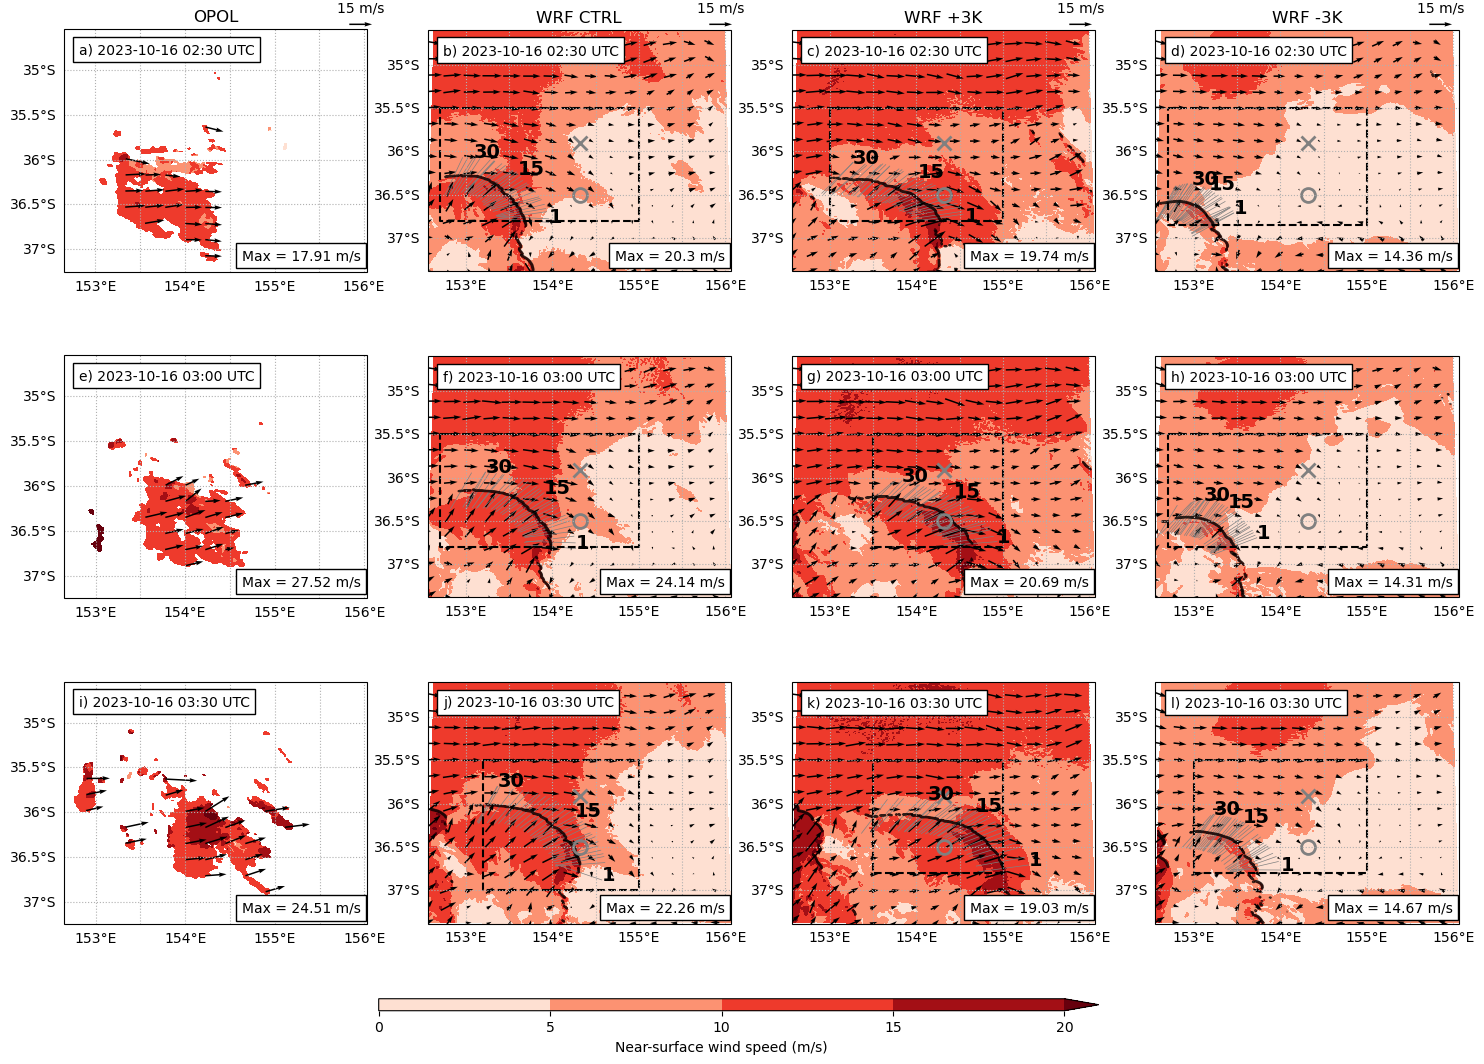

In [26]:
def plot_transect_map(ax, ctrl, ctrl_highres, ctrl_highres_wrf, ctrl_dbz, letter, grad_theta_thresh=2, title=""):
    
    
    ctrl_tstart = [ctrl.transect_starts_lon,ctrl.transect_starts_lat]
    ctrl_tend = [ctrl.transect_ends_lon,ctrl.transect_ends_lat]
    for i in ctrl.transect.values:
        plt.plot([ctrl_tstart[0][i],ctrl_tend[0][i]], [ctrl_tstart[1][i],ctrl_tend[1][i]], color="grey", ls="-", lw=0.5)
        if i in [0,14,29]:
            plt.text(ctrl_tend[0][i], ctrl_tend[1][i], str(i+1), color="k", fontdict={"weight":"bold","size":14})

    c=ax.contourf(ctrl_highres.XLONG.squeeze().values,
                  ctrl_highres.XLAT.squeeze().values,
                  (np.sqrt(ctrl_highres["U10"]**2 + ctrl_highres["V10"]**2).squeeze()).values,
                      cmap=plt.get_cmap("Reds"), levels=[0,5,10,15,20], add_colorbar=False, extend="max")
    step=46
    q=ctrl_highres.isel(Time=0,west_east=slice(0,-1,step),south_north=slice(0,-1,step))\
                .plot.quiver("XLONG","XLAT","U10","V10",scale=200,width=0.005,ax=ax,add_guide=False)
    theta = wrf.getvar(ctrl_highres_wrf, "theta").isel(bottom_top=0)
    xr.plot.contour(calc_grad_theta(theta),levels=[grad_theta_thresh],colors=["k"],x="XLONG",y="XLAT",ax=ax,alpha=0.8)
    xlim = [np.concatenate([ctrl.transect_starts_lon,ctrl.transect_ends_lon]).min()-0.1,
            np.concatenate([ctrl.transect_starts_lon,ctrl.transect_ends_lon]).max()+0.1]
    ylim = [np.concatenate([ctrl.transect_starts_lat,ctrl.transect_ends_lat]).min()-0.1,
            np.concatenate([ctrl.transect_starts_lat,ctrl.transect_ends_lat]).max() + 0.1]    
    ax.gridlines(draw_labels=["bottom","left"], ls=":")
    
    ax.set_title(title)
    
    max_bounds = [np.max([ctrl.line_xlim[0],152.7]), 155, ctrl.line_ylim[0], -35.5]
    plt.plot([max_bounds[0],max_bounds[1],max_bounds[1],max_bounds[0],max_bounds[0]],
             [max_bounds[3],max_bounds[3],max_bounds[2],max_bounds[2],max_bounds[3]], ls="--", color="k")
    max_ws = xr.where(
        ((ctrl_highres).XLONG >= max_bounds[0]) & ((ctrl_highres).XLONG <= max_bounds[1]) &\
        ((ctrl_highres).XLAT >= max_bounds[2]) & ((ctrl_highres).XLAT <= max_bounds[3]), 
        (np.sqrt(ctrl_highres["U10"]**2 + ctrl_highres["V10"]**2).squeeze()).values, np.nan).max().values    
    ax.text(0.98,0.05,"Max = "+str(np.round(max_ws,2))+" m/s",transform=ax.transAxes,bbox={"ec":"k","fc":"white"},ha="right")        
    
    ax.text(0.05,0.9,letter+") "+pd.to_datetime(ctrl.Time.values).strftime("%Y-%m-%d %H:%M UTC"),transform=ax.transAxes,bbox={"ec":"k","fc":"white"})        
    
    ax.plot(154.324, -36.5, marker="o", color="grey", ms=10, mew=2, mfc="none")
    ax.plot(154.324, -35.9070, marker="x", color="grey", ms=10, mew=2)
    
    return c,q

def plot_radar_map(ax,ctrl,t,tlats,tlons,letter,z=0,draw_transects=False,title=""):
    lon,lat,u,v = read_swirl(t,z=z,step=1)
    lon_q,lat_q,u_q,v_q = read_swirl(t,z=z,step=20)
    c=ax.contourf(lon,lat,np.sqrt(u**2+v**2),levels=[0,5,10,15,20],extend="max",cmap=plt.get_cmap("Reds"), add_colorbar=False)
    #ax.plot(154.324, -35.9070, marker="x", color="grey", ms=10, mew=2)
    q=ax.quiver(lon_q,lat_q,u_q,v_q,scale=200,width=0.005)
    ax.gridlines(draw_labels=["bottom","left"],ls=":")
    ax.set_title(title)
    ax.text(0.05,0.9,letter+") "+pd.to_datetime(ctrl.Time.values).strftime("%Y-%m-%d %H:%M UTC"),transform=ax.transAxes,bbox={"ec":"k","fc":"white"})        
    
    if draw_transects:
        for i in range(len(radar_transect_lons)):
            ax.plot(radar_transect_lons[i],radar_transect_lats[i], color="grey", ls="-", lw=0.5)
            if i in [0,10,20,30]:
                plt.text(radar_transect_lons[i][0],radar_transect_lats[i][0], str(i), color="k", fontdict={"weight":"bold","size":14})            
                
    max_ws = np.sqrt(u**2+v**2).max().values
    ax.text(0.98,0.05,"Max = "+str(np.round(max_ws,2))+" m/s",transform=ax.transAxes,bbox={"ec":"k","fc":"white"},ha="right")                                        
    
    return q
    
    
            
plt.figure(figsize=[18,12])
cnt=0
cols=4
rows=3
radar_t = ["0230","0300","0330"]
radar_transect_lats,radar_transect_lons = get_radar_transects()
radar_transect_lats = np.flip(radar_transect_lats)
radar_transect_lons = np.flip(radar_transect_lons)
letters = ["a","b","c","d","e","f","g","h","i","j","k","l"]
for i in tqdm.tqdm([0,1,2]):
    
    draw_transects=False        
    ax=plt.subplot(rows,cols,(cnt*cols)+1,projection=ccrs.PlateCarree())        
    q1=plot_radar_map(ax,ctrl_list[i],radar_t[i],radar_transect_lats,radar_transect_lons,letters[(cnt*cols)+0],draw_transects=draw_transects)
    if i == 0:
        plt.title("OPOL")    
    
    ax=plt.subplot(rows,cols,(cnt*cols)+2,projection=ccrs.PlateCarree())        
    c,q2=plot_transect_map(ax,ctrl_list[i], ctrl_highres_list[i], ctrl_highres_wrf_list[i], ctrl_dbz_list[i], letters[(cnt*cols)+1]) 
    if i == 0:
        plt.title("WRF CTRL")    
    
    ax=plt.subplot(rows,cols,(cnt*cols)+3,projection=ccrs.PlateCarree())        
    c,q3=plot_transect_map(ax,plus3K_list[i], plus3K_highres_list[i], plus3K_highres_wrf_list[i], plus3K_dbz_list[i], letters[(cnt*cols)+2])     
    if i == 0:
        plt.title("WRF +3K")    
    
    ax=plt.subplot(rows,cols,(cnt*cols)+4,projection=ccrs.PlateCarree())        
    c,q4=plot_transect_map(ax,minus3K_list[i], minus3K_highres_list[i], minus3K_highres_wrf_list[i], minus3K_dbz_list[i], letters[(cnt*cols)+3], grad_theta_thresh=1)         
    if i == 0:
        plt.title("WRF -3K")        
    
    if i == 0:
        cb = plt.colorbar(c,plt.axes([0.3,0.05,0.4,0.01]),orientation="horizontal")
        cb.set_label("Near-surface wind speed (m/s)")
    
    cnt = cnt+1    
    
plt.quiverkey(q1,0.29,0.872,15,"15 m/s",coordinates="figure")
plt.quiverkey(q2,0.49,0.872,15,"15 m/s",coordinates="figure")
plt.quiverkey(q3,0.69,0.872,15,"15 m/s",coordinates="figure")
plt.quiverkey(q4,0.89,0.872,15,"15 m/s",coordinates="figure")

plt.savefig("/g/data/w40/ab4502/IN2023_V06/figs/plan_view_wind.jpeg",dpi=500,bbox_inches="tight")

100%|██████████| 3/3 [00:15<00:00,  5.20s/it]


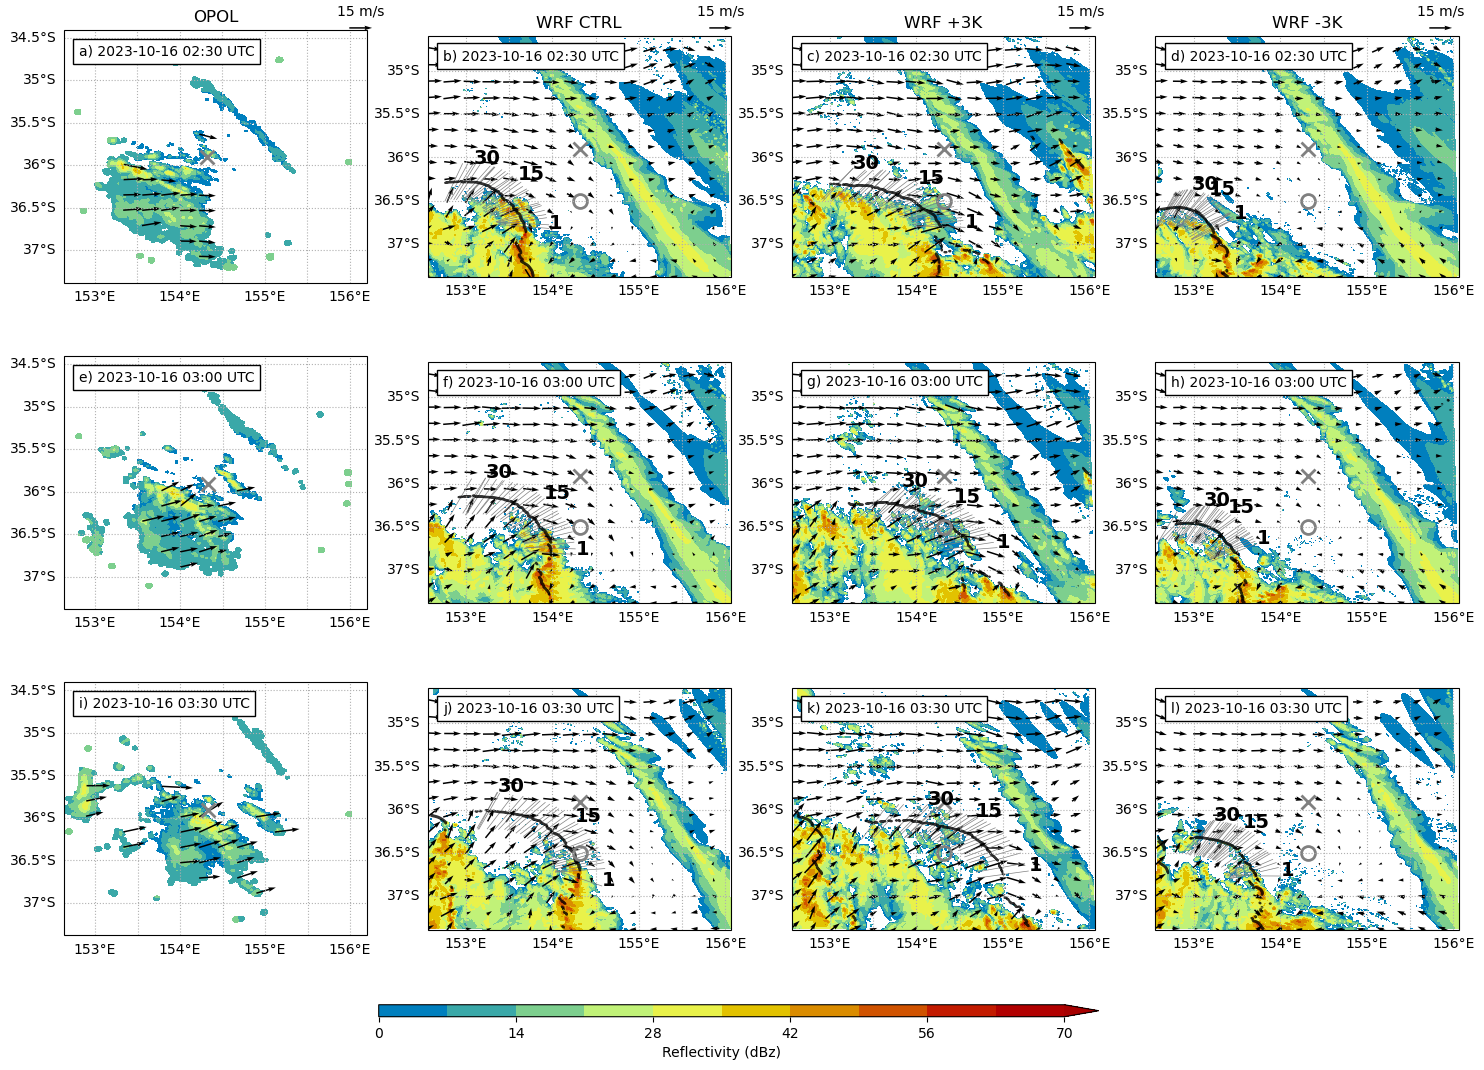

In [30]:
def plot_transect_map(ax, ctrl, ctrl_highres, ctrl_highres_wrf, ctrl_dbz, letter, grad_theta_thresh=2, title=""):
    
    
    ctrl_tstart = [ctrl.transect_starts_lon,ctrl.transect_starts_lat]
    ctrl_tend = [ctrl.transect_ends_lon,ctrl.transect_ends_lat]
    for i in ctrl.transect.values:
        plt.plot([ctrl_tstart[0][i],ctrl_tend[0][i]], [ctrl_tstart[1][i],ctrl_tend[1][i]], color="grey", ls="-", lw=0.5)
        if i in [0,14,29]:
            plt.text(ctrl_tend[0][i], ctrl_tend[1][i], str(i+1), color="k", fontdict={"weight":"bold","size":14})

    c=ax.contourf(
        ctrl_dbz.XLONG.values,
        ctrl_dbz.XLAT.values,        
        ctrl_dbz.dbz.max("bottom_top").values
        ,cmap=pyart.graph.cm_colorblind.HomeyerRainbow, levels=np.linspace(0,70,11), add_colorbar=False, extend="max")
    step=46
    q=ctrl_highres.isel(Time=0,west_east=slice(0,-1,step),south_north=slice(0,-1,step))\
                .plot.quiver("XLONG","XLAT","U10","V10",scale=200,width=0.005,ax=ax,add_guide=False)
    theta = wrf.getvar(ctrl_highres_wrf, "theta").isel(bottom_top=0)
    xr.plot.contour(calc_grad_theta(theta),levels=[grad_theta_thresh],colors=["k"],x="XLONG",y="XLAT",ax=ax,alpha=0.8)
    xlim = [np.concatenate([ctrl.transect_starts_lon,ctrl.transect_ends_lon]).min()-0.1,
            np.concatenate([ctrl.transect_starts_lon,ctrl.transect_ends_lon]).max()+0.1]
    ylim = [np.concatenate([ctrl.transect_starts_lat,ctrl.transect_ends_lat]).min()-0.1,
            np.concatenate([ctrl.transect_starts_lat,ctrl.transect_ends_lat]).max() + 0.1]    
    ax.gridlines(draw_labels=["bottom","left"], ls=":")
    
    ax.set_title(title)
    
    ax.text(0.05,0.9,letter+") "+pd.to_datetime(ctrl.Time.values).strftime("%Y-%m-%d %H:%M UTC"),transform=ax.transAxes,bbox={"ec":"k","fc":"white"})        
    
    ax.plot(154.324, -36.5, marker="o", color="grey", ms=10, mew=2, mfc="none")
    ax.plot(154.324, -35.9070, marker="x", color="grey", ms=10, mew=2)
    
    return c,q

def plot_radar_map(ax,ctrl,t,grid_t,tlats,tlons,letter,z=0,draw_transects=False,title=""):
    grid,obs_lon,obs_lat = read_grid(grid_t)
    lon_q,lat_q,u_q,v_q = read_swirl(t,z=z,step=20)
    c=ax.contourf(obs_lon, obs_lat, grid.DBZH.isel(time=0).max("z"), transform=ccrs.PlateCarree(), cmap=pyart.graph.cm_colorblind.HomeyerRainbow, 
              levels=np.linspace(0,70,11), extend="max")
    q=ax.quiver(lon_q,lat_q,u_q,v_q,scale=200,width=0.005)
    ax.gridlines(draw_labels=["bottom","left"],ls=":")
    ax.set_title(title)
    ax.text(0.05,0.9,letter+") "+pd.to_datetime(ctrl.Time.values).strftime("%Y-%m-%d %H:%M UTC"),transform=ax.transAxes,bbox={"ec":"k","fc":"white"})        
    
    if draw_transects:
        for i in range(len(radar_transect_lons)):
            ax.plot(radar_transect_lons[i],radar_transect_lats[i], color="grey", ls="-", lw=0.5)
            if i in [0,10,20,30]:
                plt.text(radar_transect_lons[i][0],radar_transect_lats[i][0], str(i), color="k", fontdict={"weight":"bold","size":14})            
                
    ax.plot(154.324, -35.9070, marker="x", color="grey", ms=10, mew=2)    
    
    return q
            
plt.figure(figsize=[18,12])
cnt=0
cols=4
radar_t = ["0230","0300","0330"]
grid_t = ["20231016_023000","20231016_030000","20231016_033000"]
radar_transect_lats,radar_transect_lons = get_radar_transects()
radar_transect_lats = np.flip(radar_transect_lats)
radar_transect_lons = np.flip(radar_transect_lons)
letters = ["a","b","c","d","e","f","g","h","i","j","k","l"]
for i in tqdm.tqdm([0,1,2]):
    
    draw_transects=False        
    ax=plt.subplot(rows,cols,(cnt*cols)+1,projection=ccrs.PlateCarree())        
    q1=plot_radar_map(ax,ctrl_list[i],radar_t[i],grid_t[i],radar_transect_lats,radar_transect_lons,letters[(cnt*cols)+0],draw_transects=draw_transects)
    if i == 0:
        plt.title("OPOL")    
    
    ax=plt.subplot(rows,cols,(cnt*cols)+2,projection=ccrs.PlateCarree())        
    c,q2=plot_transect_map(ax,ctrl_list[i], ctrl_highres_list[i], ctrl_highres_wrf_list[i], ctrl_dbz_list[i], letters[(cnt*cols)+1]) 
    if i == 0:
        plt.title("WRF CTRL")    
    
    ax=plt.subplot(rows,cols,(cnt*cols)+3,projection=ccrs.PlateCarree())        
    c,q3=plot_transect_map(ax,plus3K_list[i], plus3K_highres_list[i], plus3K_highres_wrf_list[i], plus3K_dbz_list[i], letters[(cnt*cols)+2])     
    if i == 0:
        plt.title("WRF +3K")    
    
    ax=plt.subplot(rows,cols,(cnt*cols)+4,projection=ccrs.PlateCarree())        
    c,q4=plot_transect_map(ax,minus3K_list[i], minus3K_highres_list[i], minus3K_highres_wrf_list[i], minus3K_dbz_list[i], letters[(cnt*cols)+3], grad_theta_thresh=1)         
    if i == 0:
        plt.title("WRF -3K")      
    
    if i == 0:
        cb = plt.colorbar(c,plt.axes([0.3,0.05,0.4,0.01]),orientation="horizontal")
        cb.set_label("Reflectivity (dBz)")
    
    cnt = cnt+1    
    
plt.quiverkey(q1,0.29,0.874,15,"15 m/s",coordinates="figure")
plt.quiverkey(q2,0.49,0.874,15,"15 m/s",coordinates="figure")
plt.quiverkey(q3,0.69,0.874,15,"15 m/s",coordinates="figure")
plt.quiverkey(q4,0.89,0.874,15,"15 m/s",coordinates="figure")  

plt.savefig("/g/data/w40/ab4502/IN2023_V06/figs/plan_view_radar.jpeg",dpi=500,bbox_inches="tight")

100%|██████████| 4/4 [00:12<00:00,  3.02s/it]


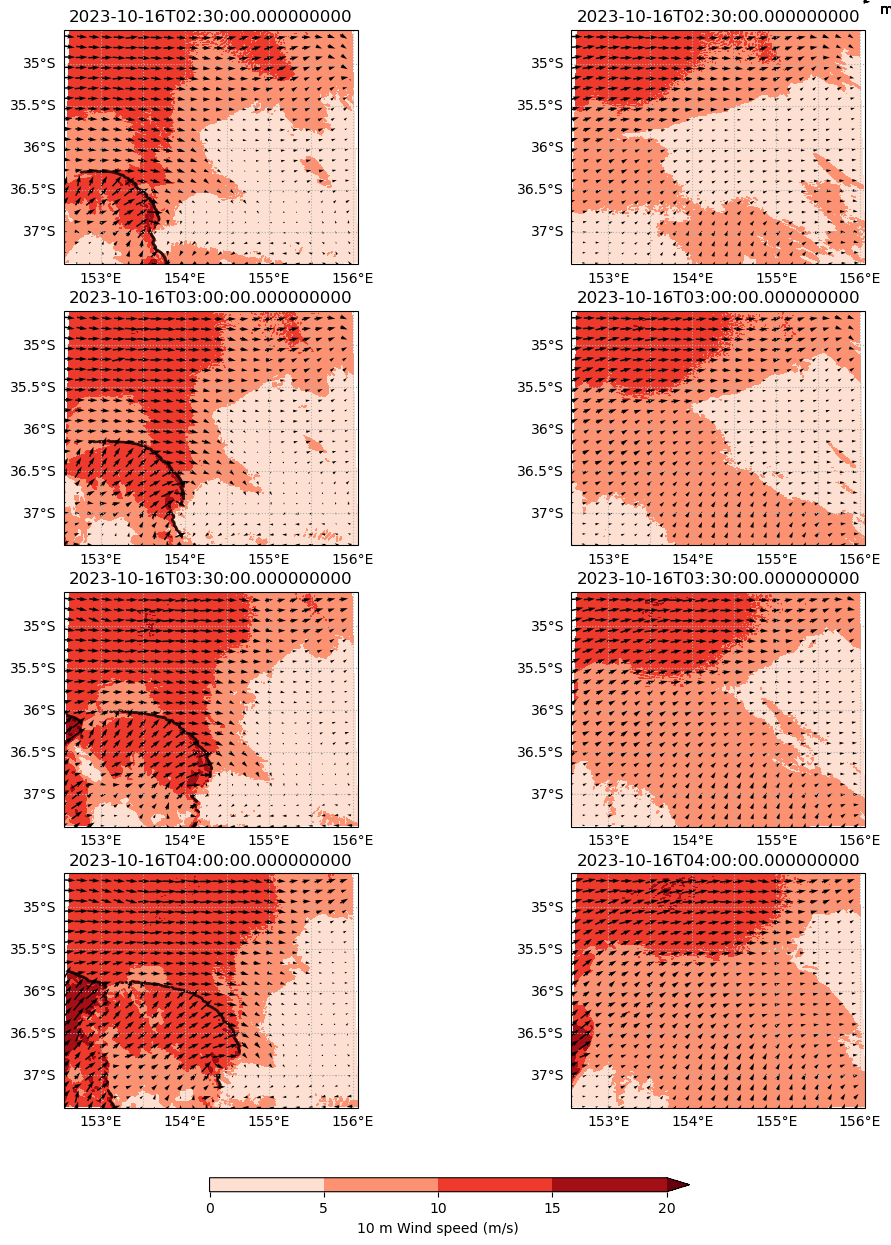

In [8]:
def plot_transect_map(ax, ctrl_highres, ctrl_highres_wrf, grad_theta_thresh=2):
    
    c=ax.contourf(ctrl_highres.XLONG.squeeze().values,
                  ctrl_highres.XLAT.squeeze().values,
                  (np.sqrt(ctrl_highres["U10"]**2 + ctrl_highres["V10"]**2).squeeze()).values,
                      cmap=plt.get_cmap("Reds"), levels=[0,5,10,15,20], add_colorbar=False, extend="max")
    ctrl_highres.isel(Time=0,west_east=slice(0,-1,30),south_north=slice(0,-1,30)).plot.quiver("XLONG","XLAT","U10","V10",scale=300,width=0.005,ax=ax)
    theta = wrf.getvar(ctrl_highres_wrf, "theta").isel(bottom_top=0)
    xr.plot.contour(calc_grad_theta(theta),levels=[grad_theta_thresh],colors=["k"],x="XLONG",y="XLAT",ax=ax,alpha=0.8)

    ax.gridlines(draw_labels=["bottom","left"], ls=":")
    ax.set_title(wrf.extract_times(ctrl_highres_wrf,0))
    
    return c
    
    
hpath = "/g/data/w40/ab4502/WRF_simulations/tasman_d04_20231015_20231016_ramssa_shortlead_no_mp_heating/"

h_fname = ["highres_d04_2023-10-16_02:30:00",
           "highres_d04_2023-10-16_03:00:00",
           "highres_d04_2023-10-16_03:30:00",
           "highres_d04_2023-10-16_04:00:00"]    
no_heating_highres_list = [xr.open_dataset(hpath+h_fname[i], decode_times=False) for i in range(len(h_fname))]
no_heating_highres_wrf_list = [nc.Dataset(hpath+h_fname[i]) for i in range(len(h_fname))]
    
plt.figure(figsize=[12,14])
cnt=0
cols=2

for i in tqdm.tqdm(range(len(ctrl_list))):
    
    if i == 2:
        draw_transects=True
    else:
        draw_transects=False        
    ax=plt.subplot(len(t_fname),cols,(cnt*cols)+1,projection=ccrs.PlateCarree())        
    c=plot_transect_map(ax, ctrl_highres_list[i], ctrl_highres_wrf_list[i]) 
    
    ax=plt.subplot(len(t_fname),cols,(cnt*cols)+2,projection=ccrs.PlateCarree())        
    c=plot_transect_map(ax, no_heating_highres_list[i], no_heating_highres_wrf_list[i])     
    
    cnt=cnt+1
        
cb = plt.colorbar(c,plt.axes([0.3,0.05,0.4,0.01]),orientation="horizontal")
cb.set_label("10 m Wind speed (m/s)")        